In [1]:
from cluster import ClusterVerbs

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


INFO     [36] Loading tensor and index..
DEBUG    [40] (100293, 18634, 110595)
INFO     [50] UMAP..
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
INFO     [55] Clustering..
DEBUG    [59] 
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be

156 clusters, sizes: 12508 4176 95 92 50 44 33 31 29 28 26 25 24 24 23 23 22 22 21 21 21 20 20 19 19 17 17 17 17 17 17 16 16 15 15 15 15 15 15 15 14 14 14 14 13 13 13 13 13 13 12 12 12 11 11 11 11 11 11 11 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 8 8 8 8 8 8 8 8..
(-1, 12508, ['rodeo', 'enjo', 'cherry-pick', 'dxc2', 'encanta', 'clothesline', 'classless', 'hrs.', 'intercool'])
(153, 4176, ['waaake', 'itsa', 'chlororaphi', 'encanto', 'caugiran', 'dzieli', 'e685dec0', 'lapok', 'catheterization-involve'])
(95, 95, ['dvidir', 'lsmod', '3.30', '3,983', '3,674', '28,992,163', '27.2', '27,474', '27,347'])
(8, 92, ['booktalk', 'underplant', 'foung', 'seent', 'nw', 'instale', 'ike', 'chown-ed', 'chron'])
(84, 50, ['box_info', 'bnc', 'do31', 'cause1', 'figure3', 'ed.', 'do43', 'vii', 'cause2'])
(96, 44, ['3,165', '274.8', '333.3', '349', '2500', '22ppd', '20/adults', '2,867', '209,998'])
(137, 33, [':316', ':313', ':218', ':2072', ':2499', ':499', ':464', '

DEBUG    [1254] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos


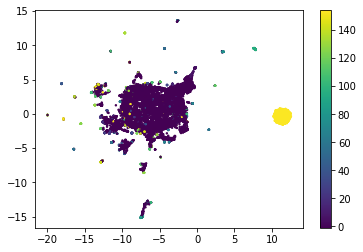

In [2]:
cv = ClusterVerbs()
cv.do_cluster()                                                       
cv.write_cluters()                                                    